# ECG Classification Without Augmentation: 
This notebook explores ECG heartbeat classification using deep learning, without applying any data augmentation techniques.


## Dataset Exploration

In [1]:
# Import necessary libraries

import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
from matplotlib import pyplot as plt  # For data visualization
from sklearn.model_selection import train_test_split  # For splitting the dataset into train and test sets


In [2]:
# Load the ECG training dataset from a CSV file
# The dataset does not have predefined headers, so we set `header=None`
df_train = pd.read_csv("../Data/mitbih_train.csv", header=None)

# Load the ECG test dataset from a CSV file
# This dataset will be used for evaluating the model's performance
df_test = pd.read_csv("../Data/mitbih_test.csv", header=None)

In [3]:
# Check the Dimension of the Set
print(f"Training dataset shape: {df_train.shape} (rows, columns)")

print(f"Test dataset shape: {df_test.shape} (rows, columns)")

Training dataset shape: (87554, 188) (rows, columns)
Test dataset shape: (21892, 188) (rows, columns)


In [4]:
print("🔹 Label distribution in Training Set:")
print(df_train.iloc[:, -1].value_counts())

print("\n🔹 Label distribution in Test Set:")
print(df_test.iloc[:, -1].value_counts())

🔹 Label distribution in Training Set:
187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

🔹 Label distribution in Test Set:
187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


# Data Preprocessing

In [5]:
import sys

# Add the 'src' directory to the Python path so we can import custom utility functions
sys.path.append("../src")  

# Import the stratified sampling function from utils.py
from utils import stratified_sample  


df_validation , df_train = stratified_sample(df_train, 3)

X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_validation = df_validation.iloc[:, :-1]
y_validation = df_validation.iloc[:,-1]


# X_holdout = X_holdout.reset_index(drop=True)
# y_holdout = y_holdout.reset_index(drop=True)
# Identify the distribution of classes in the training set
class_distribution = y_train.value_counts().sort_values()

# Select the three least represented classes (minority classes)
minority_classes = class_distribution.index[:3]

# Print the identified minority classes
print(f"Minority classes: {minority_classes.tolist()}")

# Display the class distribution in the training set
# This helps assess dataset imbalance and decide on augmentation strategies
print("Class distribution in the training set:")
print(class_distribution)


Minority classes: [3.0, 1.0, 2.0]
Class distribution in the training set:
187
3.0      641
1.0     2223
2.0     5788
4.0     6431
0.0    69846
Name: count, dtype: int64


In [6]:
X_test, X_holdout, y_test, y_holdout = train_test_split(
    df_test.iloc[:, :-1],  # Features from test set
    df_test.iloc[:, -1],   # Labels from test set
    test_size=0.5,         # 50% of test data goes into the holdout set
    random_state=42        # Ensure reproducibility
)

In [7]:
# Print the class distribution in the validation set
# This helps verify that stratified sampling preserved the class balance
print(y_validation.value_counts())

# Print the class distribution in the training set
# Ensures we have a clear understanding of how many samples exist for each class
print(y_train.value_counts())

187
0.0    525
3.0    525
2.0    525
4.0    525
1.0    525
Name: count, dtype: int64
187
0.0    69846
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


In [8]:
# Identify the minority classes
class_distribution = y_train.value_counts().sort_values()
minority_classes = class_distribution.index[:3]
print(f"Minority classes: {minority_classes.tolist()}")
print("Class distribution in the training set:")
print(class_distribution)

Minority classes: [3.0, 1.0, 2.0]
Class distribution in the training set:
187
3.0      641
1.0     2223
2.0     5788
4.0     6431
0.0    69846
Name: count, dtype: int64


In [9]:
#%% Prepare Data

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from cnn_lstm_classifier import CNNLSTMClassifier  # Assuming the model class is in the src directory

X_data = np.expand_dims(X_train.values, axis=-1)  # Add channel dimension for CNN
y_data = y_train.values

print(f"Input shape for model: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")


Input shape for model: (84929, 187, 1)
Labels shape: (84929,)


## Model Selection & Implementation

In [10]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
from data_augmentation import DataAugmentation  # Assuming the class is in the src folder
from cnn_lstm_classifier import CNNLSTMClassifier  # Assuming the model class is in the src directory


# To store evaluation metrics
accuracy_scores = []
classification_reports = []
confusion_matrices = []


## Initialize the model and training : 

In [11]:
# Import necessary libraries for model evaluation and visualization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
import numpy as np
import seaborn as sns

# Initialize the CNN + LSTM model with specified parameters
model = CNNLSTMClassifier(
    input_shape=(187, 1),  # Input shape matches the ECG signal length and single-channel format
    num_classes=len(np.unique(y_data)),  # Automatically determine the number of classes
    learning_rate=1e-3,  # Set an appropriate learning rate for training
    batch_size=32,  # Define batch size for training
    epochs=50  # Set the number of epochs for training
)

# Train the model using the training dataset
# This step involves feeding the training data to the model and optimizing weights
print("\nStarting model training...")
model.fit(X_data, y_data, X_validation, y_validation)



Starting model training...
Epoch 1/50
2653/2655 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8273 - loss: 0.6702
Epoch 1: val_accuracy improved from inf to 0.42400, saving model to saved_model.h5


2655/2655 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.8273 - loss: 0.6701 - val_accuracy: 0.4240 - val_loss: 2.1640 - learning_rate: 0.0010
Epoch 2/50
2654/2655 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8945 - loss: 0.3866
Epoch 2: val_accuracy did not improve from 0.42400
2655/2655 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.8945 - loss: 0.3865 - val_accuracy: 0.5204 - val_loss: 1.8507 - learning_rate: 0.0010
Epoch 3/50
2655/2655 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9167 - loss: 0.3202
Epoch 3: val_accuracy did not improve from 0.42400
2655/2655 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.9167 - loss: 0.3202 - val_accuracy: 0.5550 - val_loss: 1.4482 - learning_rate: 0.0010
Epoch 4/50
2654/2655 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9290 - loss: 0.2732
Epoch 4: val_accuracy did not improve from 0.42400
2655/2655 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.9290 - loss: 0.2732 - val_accuracy: 0.5726 - val_loss: 1.2896 - learning_rate: 0.0010


## Model Evaluation

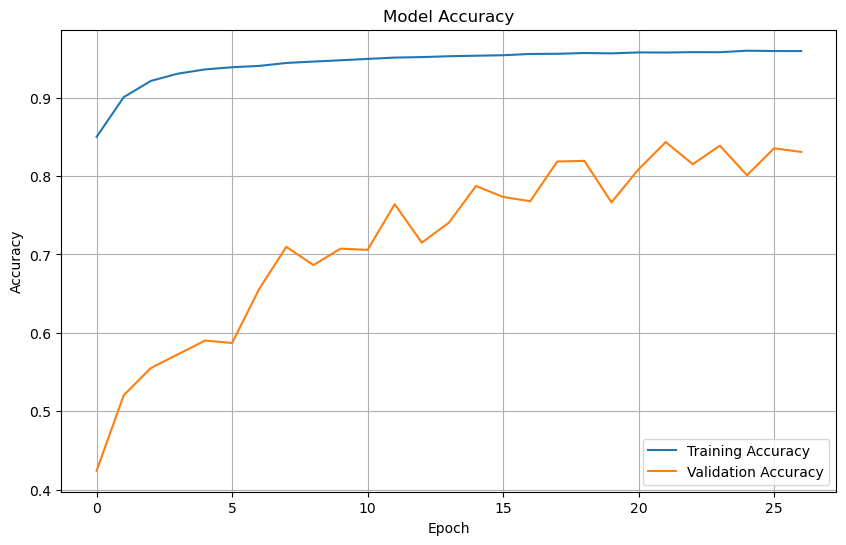


Evaluating on Validation Set...
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

         0.0       0.29      0.99      0.45       525
         1.0       1.00      0.10      0.18       525
         2.0       0.92      0.15      0.26       525
         3.0       0.00      0.00      0.00       525
         4.0       0.67      0.88      0.76       525

    accuracy                           0.42      2625
   macro avg       0.58      0.42      0.33      2625
weighted avg       0.58      0.42      0.33      2625



/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


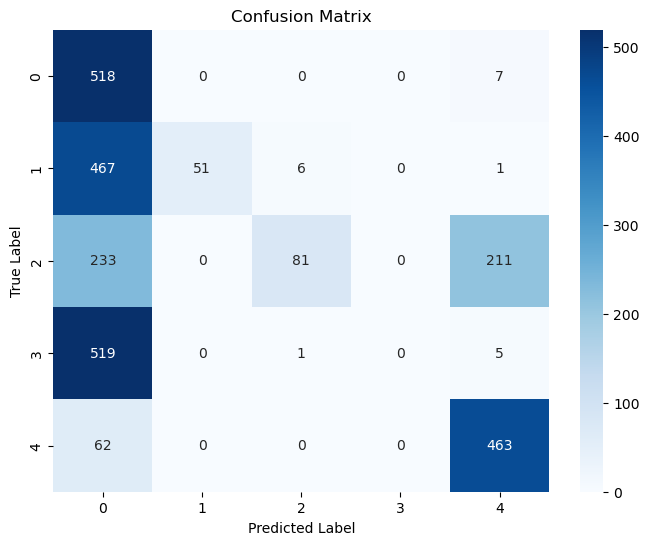

In [12]:
# Plot the accuracy and loss curves to visualize the training process
# Helps in identifying underfitting or overfitting
model.plot_history()

# Evaluate the model using the validation dataset
# This provides insights into how well the model generalizes to unseen data
print("\nEvaluating on Validation Set...")
model.evaluate(X_validation, y_validation)

In [13]:
# Load the best model to make predictions
best_model = keras.models.load_model('saved_model.h5')

# Predict on the validation set using the best model
y_val_pred = best_model.predict(X_validation)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Calculate and display accuracy
accuracy = accuracy_score(y_validation, y_val_pred_classes)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Generate and display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_validation, y_val_pred_classes, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_validation, y_val_pred_classes))


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Validation Accuracy: 0.4240

Classification Report:
              precision    recall  f1-score   support

         0.0     0.2879    0.9867    0.4458       525
         1.0     1.0000    0.0971    0.1771       525
         2.0     0.9205    0.1543    0.2643       525
         3.0     0.0000    0.0000    0.0000       525
         4.0     0.6739    0.8819    0.7640       525

    accuracy                         0.4240      2625
   macro avg     0.5765    0.4240    0.3302      2625
weighted avg     0.5765    0.4240    0.3302      2625


Confusion Matrix:
[[518   0   0   0   7]
 [467  51   6   0   1]
 [233   0  81   0 211]
 [519   0   1   0   5]
 [ 62   0   0   0 463]]


/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## test set

Test set shape: (10946, 187, 1)
Test labels shape: (10946,)


Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0     0.9224    0.9916    0.9557      9012
         1.0     0.7857    0.0761    0.1388       289
         2.0     0.9583    0.1830    0.3073       754
         3.0     0.0000    0.0000    0.0000        78
         4.0     0.6703    0.8954    0.7667       813

    accuracy                         0.8975     10946
   macro avg     0.6674    0.4292    0.4337     10946
weighted avg     0.8960    0.8975    0.8686     10946

Accuracy on Test Set: 0.8975


/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


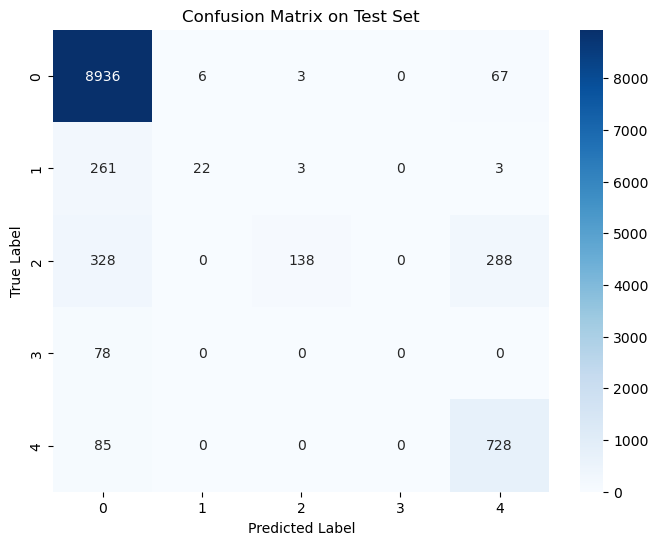

In [14]:
#%% evlauate the model with the test set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow import keras

# Ensure the test data has the correct shape
X_test = np.expand_dims(X_test, axis=-1)  # Add channel dimension if not already added
print(f"Test set shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")


# Predict on the test set
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Generate classification report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred_classes, digits=4))

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_classes)
print(f"Accuracy on Test Set: {test_accuracy:.4f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.savefig("Confusion Matrix on Test Set" , bbox_inches='tight', dpi=300)
plt.show()

Prepared holdout set shape for augmentation: (10946, 187, 1)
Noisy holdout set shape: (10946, 187, 1)
Noisy holdout labels shape: (10946,)

Evaluating on the Noisy Holdout Set...
Noisy Holdout Set Accuracy: 0.9031

Classification Report for Noisy Holdout Set:
              precision    recall  f1-score   support

         0.0     0.9244    0.9918    0.9569      9106
         1.0     0.8571    0.0899    0.1627       267
         2.0     0.9070    0.1686    0.2843       694
         3.0     0.0000    0.0000    0.0000        84
         4.0     0.6997    0.8969    0.7861       795

    accuracy                         0.9031     10946
   macro avg     0.6776    0.4294    0.4380     10946
weighted avg     0.8982    0.9031    0.8751     10946



/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


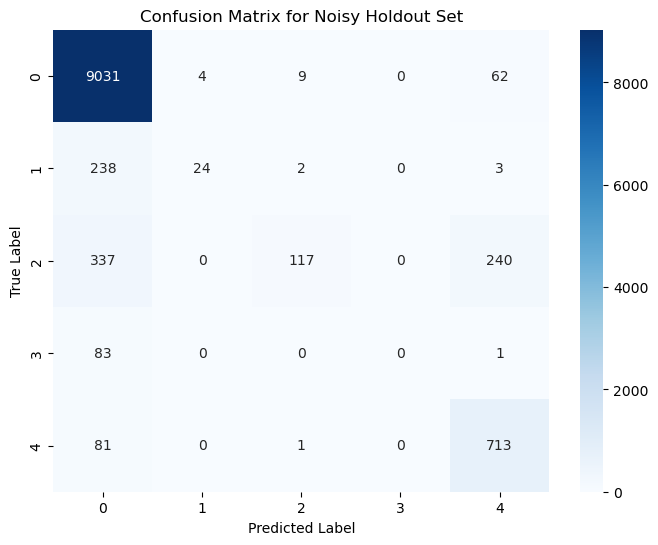

In [17]:
import numpy as np
from data_augmentation import DataAugmentation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

# Initialize the Data Augmentation class for noise injection
augmenter = DataAugmentation(
    shift_max=0,       # No time shift
    noise_level=0.1,   # Introduce significant noise
    scale_range=(1.0, 1.0), # No scaling
    expected_length=187
)

# 🆕 Prepare holdout data with the channel dimension for augmentation
X_holdout_prepared = np.expand_dims(X_holdout, axis=-1)  # Shape should be (samples, 187, 1)
y_holdout = y_holdout

#%%
print(f"Prepared holdout set shape for augmentation: {X_holdout_prepared.shape}")

# Apply noise to the holdout set with an augmentation factor of 1 (100% of samples)
X_holdout_noisy = augmenter.augment_batch(X_holdout_prepared, augmentation_factor=1.0)

# 🆕 Set the labels for the augmented noisy holdout set
num_original_samples = len(y_holdout)
num_augmented_samples = X_holdout_noisy.shape[0]

# Generate the correct number of labels for the augmented samples
y_holdout_noisy = np.repeat(y_holdout, np.ceil(num_augmented_samples / num_original_samples).astype(int))[:num_augmented_samples]

print(f"Noisy holdout set shape: {X_holdout_noisy.shape}")
print(f"Noisy holdout labels shape: {y_holdout_noisy.shape}")

# Load the best model
#model = keras.models.load_model('best_model.h5')

# Evaluate on the noisy holdout set
print("\nEvaluating on the Noisy Holdout Set...")
y_holdout_pred = model.predict(X_holdout_noisy)
y_holdout_pred_classes = np.argmax(y_holdout_pred, axis=1)

# Calculate accuracy for the noisy holdout set
holdout_accuracy = accuracy_score(y_holdout_noisy, y_holdout_pred_classes)
print(f"Noisy Holdout Set Accuracy: {holdout_accuracy:.4f}")

# Generate classification report for the noisy holdout set
print("\nClassification Report for Noisy Holdout Set:")
print(classification_report(y_holdout_noisy, y_holdout_pred_classes, digits=4))

# Generate confusion matrix for the noisy holdout set
conf_matrix_holdout = confusion_matrix(y_holdout_noisy, y_holdout_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_holdout, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Noisy Holdout Set')
plt.savefig("Confusion Matrix for Noisy Holdout Set" , bbox_inches='tight', dpi=300)
plt.show()

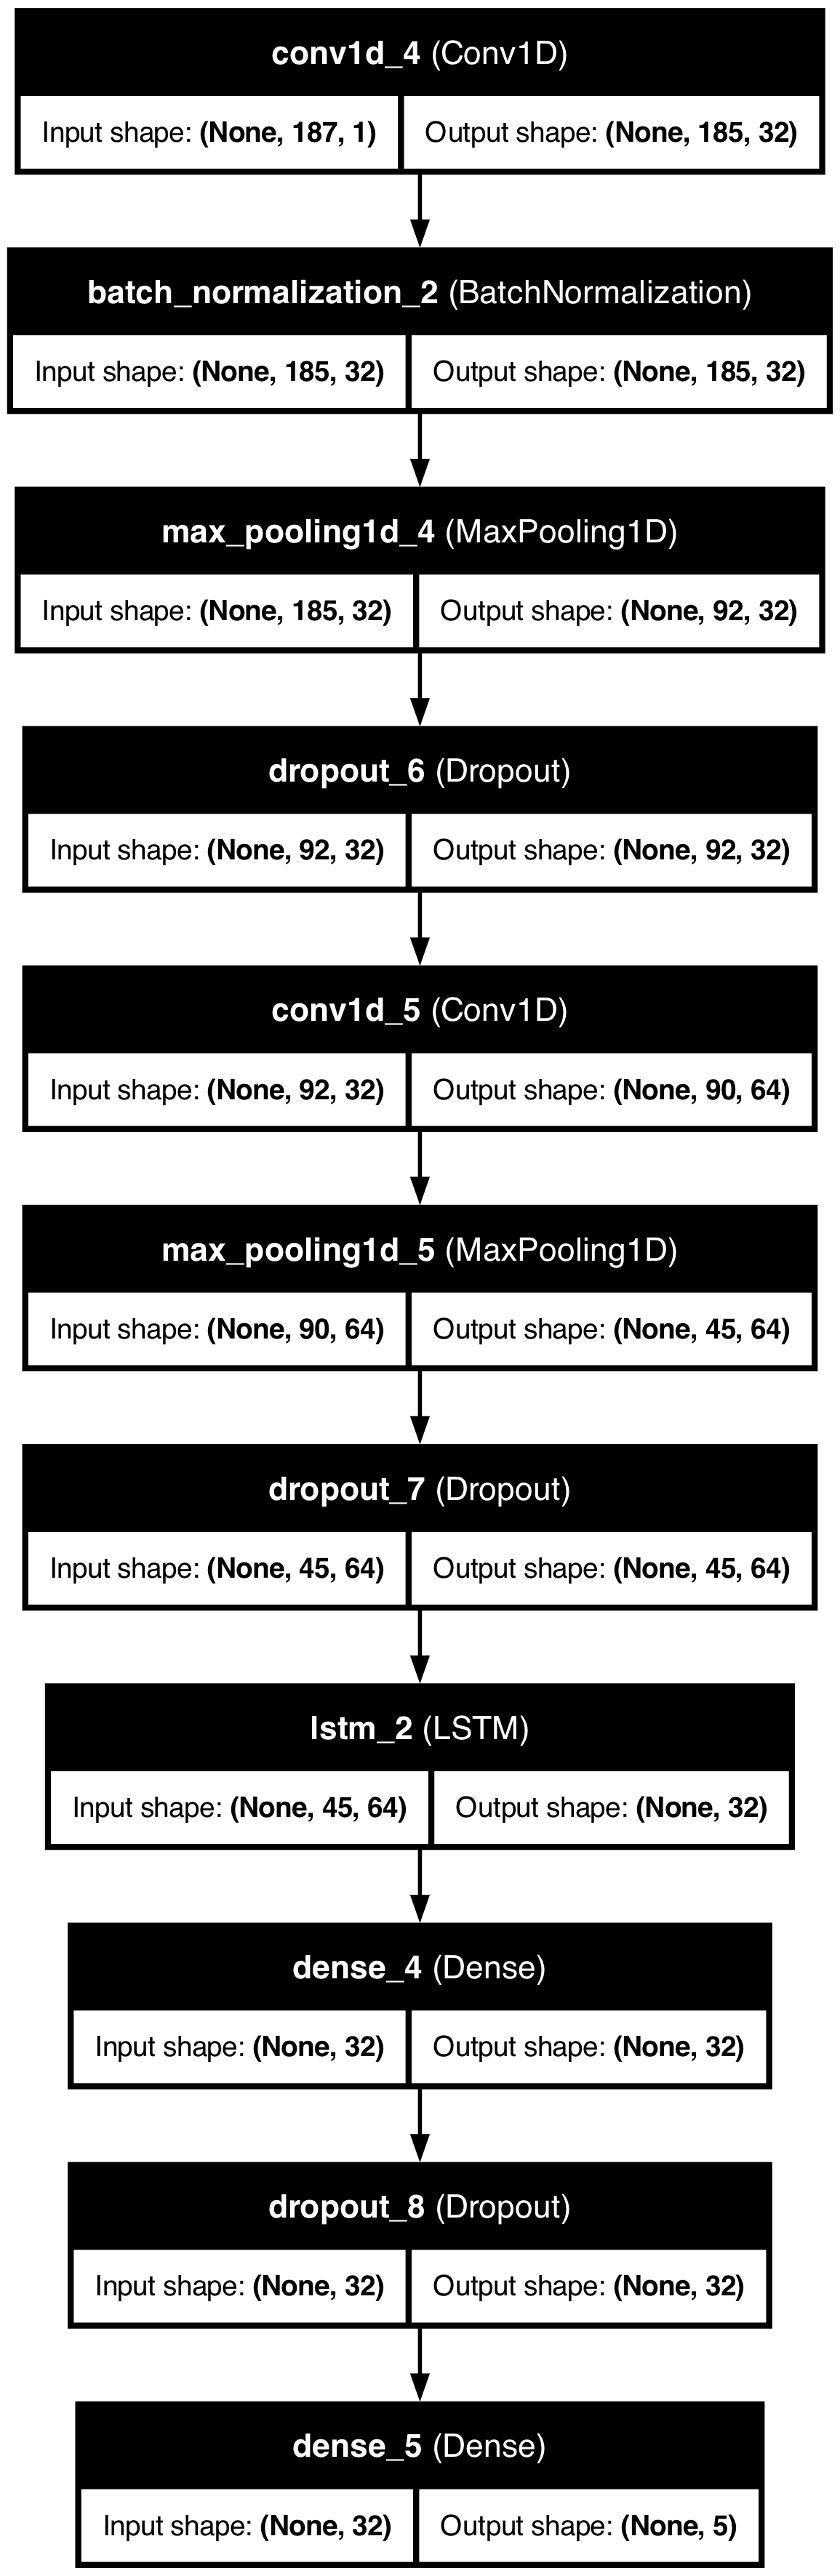

In [18]:
from tensorflow.keras.utils import plot_model
from cnn_lstm_classifier import CNNLSTMClassifier  # Assuming the model class is in the src directory

# Create model instance
model = CNNLSTMClassifier(input_shape=(187, 1), num_classes=5)

# Build the model explicitly before plotting
model.model.build(input_shape=(None, 187, 1))

# Plot the model architecture
plot_model(model.model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)
